### Forecast de demanda: Facturapp

#### ✅ XGBoost

##### Datos

In [146]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [147]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [148]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado

,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


Conclusión: Nuestro primer pronóstico agregado va a ser sólo para moneda_venta = $.

In [149]:
# Ver los valores únicos en la columna 'moneda_venta'
print(ventas_df['moneda_venta'].unique())

['$  ' 'U$S']


In [150]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df_prophet = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head()


,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


##### Para modelar vacaciones y eventos especiales con selección manual

In [151]:
import pandas as pd

# Lista de los nombres de los feriados
holiday_names = ['Año Nuevo', 'Reyes', 'Carnaval', 'Semana Santa', 'Día del Trabajador', 'Natalicio de Artigas', 
                 'Jura de la Constitución', 'Declaratoria de la Independencia', 'Día de la Raza', 'Día de los Difuntos', 'Navidad']

# Fechas base de los feriados (solo un año de ejemplo, luego generaremos para otros años)
holiday_dates = ['01-01', '01-06', '02-12', '03-28', '05-01', '06-19', '07-18', '08-25', '10-12', '11-02', '12-25']

# Crear una lista vacía para almacenar los feriados
all_holidays = []

# Generar los feriados para los años desde 2022 hasta 2026
for year in range(2022, 2027):
    for i, date in enumerate(holiday_dates):
        all_holidays.append({
            'holiday': holiday_names[i],
            'ds': pd.to_datetime(f'{year}-{date}'),
            'lower_window': -3,  # Afecta 3 días antes del feriado
            'upper_window': 3    # Afecta 3 días después del feriado
        })

# Convertir la lista de diccionarios a un DataFrame de pandas
holidays_uruguay = pd.DataFrame(all_holidays)

# Mostrar los primeros datos
holidays_uruguay.head(11)


,holiday,ds,lower_window,upper_window
0,Año Nuevo,2022-01-01,-3,3
1,Reyes,2022-01-06,-3,3
2,Carnaval,2022-02-12,-3,3
3,Semana Santa,2022-03-28,-3,3
4,Día del Trabajador,2022-05-01,-3,3
5,Natalicio de Artigas,2022-06-19,-3,3
6,Jura de la Constitución,2022-07-18,-3,3
7,Declaratoria de la Independencia,2022-08-25,-3,3
8,Día de la Raza,2022-10-12,-3,3
9,Día de los Difuntos,2022-11-02,-3,3


##### Para modelar season

In [108]:
def get_season(date):
    year = date.year
    # Definir las fechas aproximadas de inicio de las estaciones (hemisferio sur)
    verano_start = pd.to_datetime(f'{year}-12-21')
    otoño_start = pd.to_datetime(f'{year}-03-21')
    invierno_start = pd.to_datetime(f'{year}-06-21')
    primavera_start = pd.to_datetime(f'{year}-09-21')
    
    if date >= verano_start or date < otoño_start:
        return 'Verano'
    elif date >= otoño_start and date < invierno_start:
        return 'Otoño'
    elif date >= invierno_start and date < primavera_start:
        return 'Invierno'
    else:
        return 'Primavera'

In [109]:
# Aplicar la función al DataFrame para crear la columna 'season'
df['season'] = df['ds'].apply(get_season)

# Convertir la columna 'season' en variables dummy
df = pd.get_dummies(df, columns=['season'])

In [110]:
df.head()

,ds,y,season_Invierno,season_Otoño,season_Primavera,season_Verano
0,2022-04-16,39.000,False,True,False,False
1,2022-04-17,165.640,False,True,False,False
2,2022-04-18,2235.130,False,True,False,False
3,2022-04-19,1167.624,False,True,False,False
4,2022-04-20,1734.857,False,True,False,False


##### Train y test set

In [152]:
TEST_DATE = '2024-01-15'

df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]


print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

Datos de training:  550  -  82.0 %
Datos de testing:  119  -  18.0 %


#### XGBoost mejor versión

##### Opción 0: Con holidays + normalización + escalado

RMSE en el conjunto de test: 820.053600521623
MSE en el conjunto de test: 672487.9077284776
MAPE en el conjunto de test: 260.70%

       Fecha    Actual    Predicted
0 2024-01-15  2858.739  2051.846436
1 2024-01-16  3009.568  2108.432373
2 2024-01-17  2148.314  2609.229736
3 2024-01-18  2786.417  2135.203125
4 2024-01-19  2496.509  1875.091431


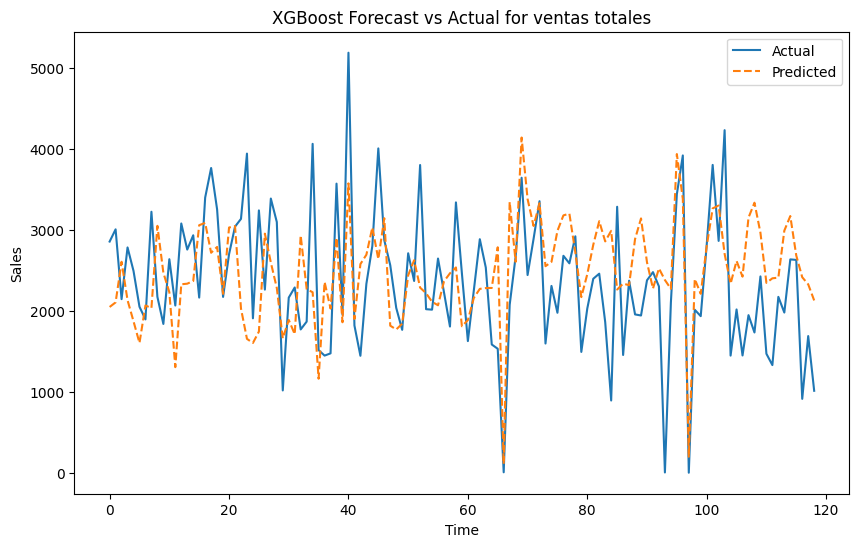

In [153]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

scaler = StandardScaler()

# Crear características adicionales a partir de la columna de fechas 'ds'
df_train['ds'] = pd.to_datetime(df_train['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df_train['day_of_week'] = df_train['ds'].dt.dayofweek
df_train['day_of_month'] = df_train['ds'].dt.day
df_train['month'] = df_train['ds'].dt.month
df_train['year'] = df_train['ds'].dt.year
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_train y df_test
df_train = pd.merge(df_train, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_train['is_holiday'] = df_train['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_train = df_train.drop(columns=['holiday'])


# Aseguramos que df_test tenga las mismas transformaciones
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test['day_of_week'] = df_test['ds'].dt.dayofweek
df_test['day_of_month'] = df_test['ds'].dt.day
df_test['month'] = df_test['ds'].dt.month
df_test['year'] = df_test['ds'].dt.year
df_test['is_weekend'] = df_test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_test
df_test = pd.merge(df_test, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_test['is_holiday'] = df_test['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_test = df_test.drop(columns=['holiday'])

# Dividimos los datos en variables predictoras (X) y objetivo (y)
X_train = df_train.drop(columns=['y', 'ds'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y', 'ds'])
y_test = df_test['y']

# Escalamos los datos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convertimos los datos a DMatrix, que es la estructura de datos que usa XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Definimos los parámetros del modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'eval_metric': 'rmse',            # Usamos RMSE como métrica de evaluación
    'max_depth': 6,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'n_estimators': 100,              # Número de árboles
    'seed': 42                        # Fijamos una semilla para reproducibilidad
}

# Entrenamos el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizamos predicciones en el conjunto de test
y_pred = model.predict(dtest)

# Calculamos el error cuadrático medio (RMSE) en el conjunto de test
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calculamos el MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Opción: convertir a DataFrame las predicciones
df_results = pd.DataFrame({'Fecha': df_test['ds'], 'Actual': y_test, 'Predicted': y_pred})

print()

# Mostrar resultados
print(df_results.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual')
plt.plot(df_results['Predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

Implementar GridSearchCV para la optimización de hiperparámetros

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1}
RMSE en el conjunto de test: 812.1885829086842
MSE en el conjunto de test: 659650.2942072166
MAPE en el conjunto de test: 382.72%
       Fecha    Actual    Predicted
0 2024-01-15  2858.739  1725.010986
1 2024-01-16  3009.568  1913.689453
2 2024-01-17  2148.314  2704.354492
3 2024-01-18  2786.417  1865.560547
4 2024-01-19  2496.509  2073.962646


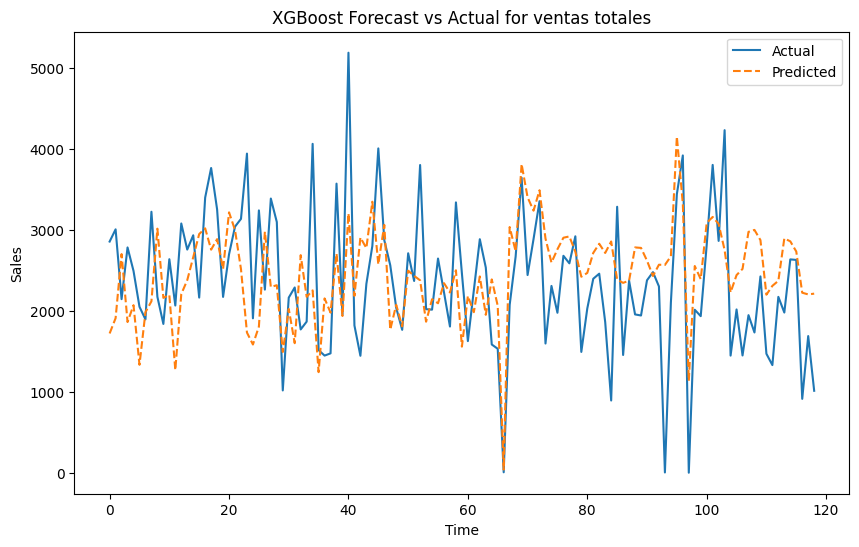

In [154]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definir los hiperparámetros que queremos probar
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.01],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7],
    'n_estimators': [1000],
    'min_child_weight': [5]
}

# Crear el modelo XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', seed=42)

# Configurar GridSearchCV para la optimización
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, verbose=1)

# Entrenar el modelo con la optimización de hiperparámetros
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Utilizar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_

# Realizamos predicciones en el conjunto de test con el mejor modelo
y_pred = best_model.predict(X_test_scaled)

# Calculamos el error cuadrático medio (RMSE) en el conjunto de test
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calculamos el MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Opción: convertir a DataFrame las predicciones
df_results = pd.DataFrame({'Fecha': df_test['ds'], 'Actual': y_test, 'Predicted': y_pred})

# Mostrar resultados
print(df_results.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual')
plt.plot(df_results['Predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

##### Opción 1: Con holidays

RMSE en el conjunto de test: 820.053600521623
MSE en el conjunto de test: 672487.9077284776
MAPE en el conjunto de test: 260.70%

       Fecha    Actual    Predicted
0 2024-01-15  2858.739  2051.846436
1 2024-01-16  3009.568  2108.432373
2 2024-01-17  2148.314  2609.229736
3 2024-01-18  2786.417  2135.203125
4 2024-01-19  2496.509  1875.091431


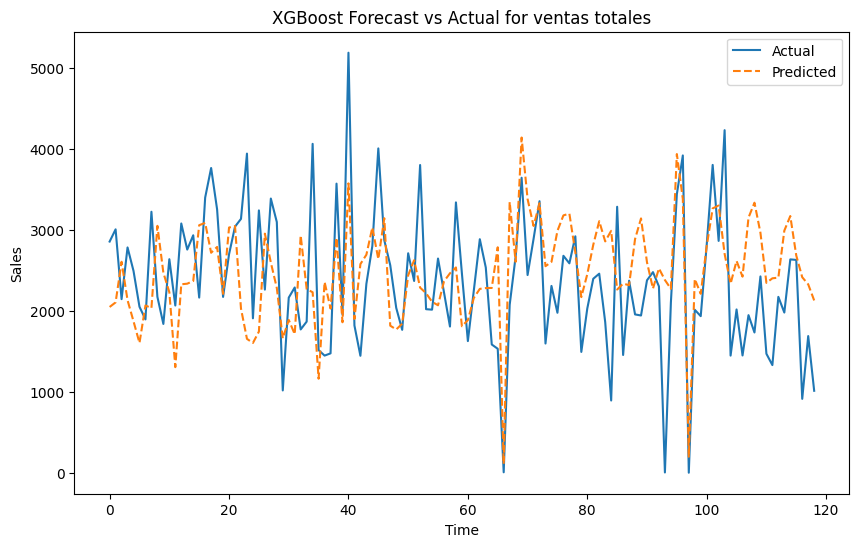

In [123]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características adicionales a partir de la columna de fechas 'ds'
df_train['ds'] = pd.to_datetime(df_train['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df_train['day_of_week'] = df_train['ds'].dt.dayofweek
df_train['day_of_month'] = df_train['ds'].dt.day
df_train['month'] = df_train['ds'].dt.month
df_train['year'] = df_train['ds'].dt.year
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_train y df_test
df_train = pd.merge(df_train, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_train['is_holiday'] = df_train['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_train = df_train.drop(columns=['holiday'])


# Aseguramos que df_test tenga las mismas transformaciones
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test['day_of_week'] = df_test['ds'].dt.dayofweek
df_test['day_of_month'] = df_test['ds'].dt.day
df_test['month'] = df_test['ds'].dt.month
df_test['year'] = df_test['ds'].dt.year
df_test['is_weekend'] = df_test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_test
df_test = pd.merge(df_test, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_test['is_holiday'] = df_test['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_test = df_test.drop(columns=['holiday'])

# Dividimos los datos en variables predictoras (X) y objetivo (y)
X_train = df_train.drop(columns=['y', 'ds'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y', 'ds'])
y_test = df_test['y']

# Convertimos los datos a DMatrix, que es la estructura de datos que usa XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definimos los parámetros del modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'eval_metric': 'rmse',            # Usamos RMSE como métrica de evaluación
    'max_depth': 6,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'n_estimators': 100,              # Número de árboles
    'seed': 42                        # Fijamos una semilla para reproducibilidad
}

# Entrenamos el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizamos predicciones en el conjunto de test
y_pred = model.predict(dtest)

# Calculamos el error cuadrático medio (RMSE) en el conjunto de test
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calculamos el MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Opción: convertir a DataFrame las predicciones
df_results = pd.DataFrame({'Fecha': df_test['ds'], 'Actual': y_test, 'Predicted': y_pred})

print()

# Mostrar resultados
print(df_results.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual')
plt.plot(df_results['Predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

###### Feature importance

RMSE en el conjunto de test: 820.053600521623
MSE en el conjunto de test: 672487.9077284776
MAPE en el conjunto de test: 260.70%


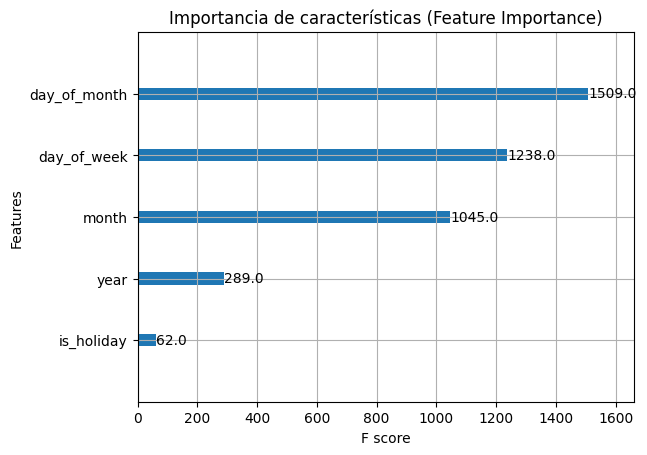

In [98]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Entrenar el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizar la predicción
y_pred = model.predict(dtest)

# Calcular el RMSE y MAPE como antes
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Importancia de las características
xgb.plot_importance(model)
plt.title('Importancia de características (Feature Importance)')
plt.show()


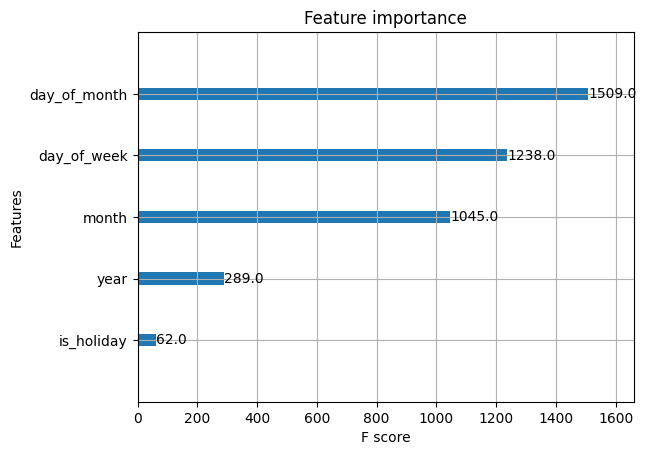

In [99]:
xgb.plot_importance(model, max_num_features=10)
plt.show()


##### Opción 2: sin holidays, sin optimización

RMSE en el conjunto de test: 832.9635944725486
MSE en el conjunto de test: 693828.3497166284
MAPE en el conjunto de test: 306.53%

         Fecha    Actual    Predicted
550 2024-01-15  2858.739  1758.269165
551 2024-01-16  3009.568  2267.489258
552 2024-01-17  2148.314  2705.919922
553 2024-01-18  2786.417  1940.408936
554 2024-01-19  2496.509  1753.326416


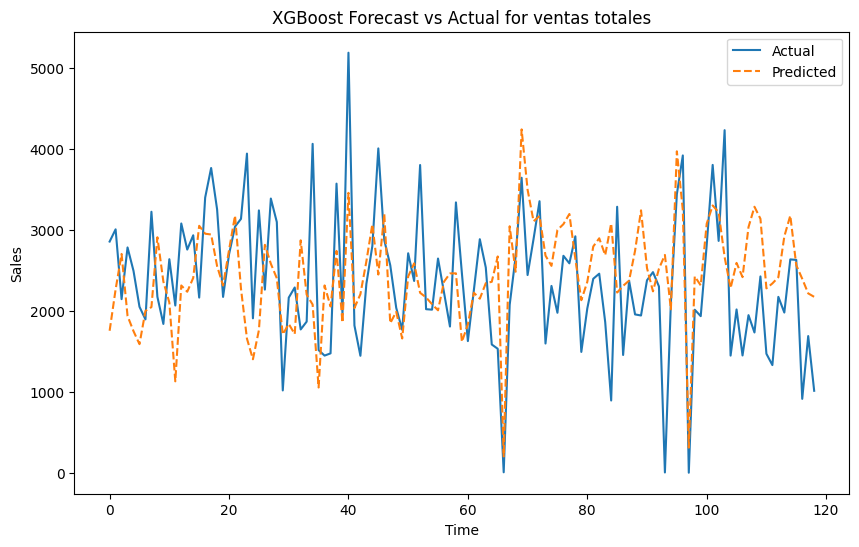

In [89]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características adicionales a partir de la columna de fechas 'ds'
df_train['ds'] = pd.to_datetime(df_train['ds'])

# Crear características basadas en la fecha
df_train['day_of_week'] = df_train['ds'].dt.dayofweek
df_train['day_of_month'] = df_train['ds'].dt.day
df_train['month'] = df_train['ds'].dt.month
df_train['year'] = df_train['ds'].dt.year
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Aseguramos que df_test tenga las mismas transformaciones
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test['day_of_week'] = df_test['ds'].dt.dayofweek
df_test['day_of_month'] = df_test['ds'].dt.day
df_test['month'] = df_test['ds'].dt.month
df_test['year'] = df_test['ds'].dt.year
df_test['is_weekend'] = df_test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Dividimos los datos en variables predictoras (X) y objetivo (y)
X_train = df_train.drop(columns=['y', 'ds'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y', 'ds'])
y_test = df_test['y']

# Convertimos los datos a DMatrix, que es la estructura de datos que usa XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definimos los parámetros del modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'eval_metric': 'rmse',            # Usamos RMSE como métrica de evaluación
    'max_depth': 6,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'n_estimators': 100,              # Número de árboles
    'seed': 42                        # Fijamos una semilla para reproducibilidad
}

# Entrenamos el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizamos predicciones en el conjunto de test
y_pred = model.predict(dtest)

# Calculamos el error cuadrático medio (RMSE) en el conjunto de test
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calculamos el MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Opción: convertir a DataFrame las predicciones
df_results = pd.DataFrame({'Fecha': df_test['ds'], 'Actual': y_test, 'Predicted': y_pred})

print()

# Mostrar resultados
print(df_results.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual')
plt.plot(df_results['Predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

##### Opción 3: Con holidays + season + optimización de hiperparámetros

RMSE en el conjunto de test: 826.6933347380839
MSE en el conjunto de test: 683421.8697003736
MAPE en el conjunto de test: 254.30%

       Fecha    Actual    Predicted
0 2024-01-15  2858.739  2027.221558
1 2024-01-16  3009.568  2328.039062
2 2024-01-17  2148.314  2746.098389
3 2024-01-18  2786.417  2016.396362
4 2024-01-19  2496.509  1926.696167


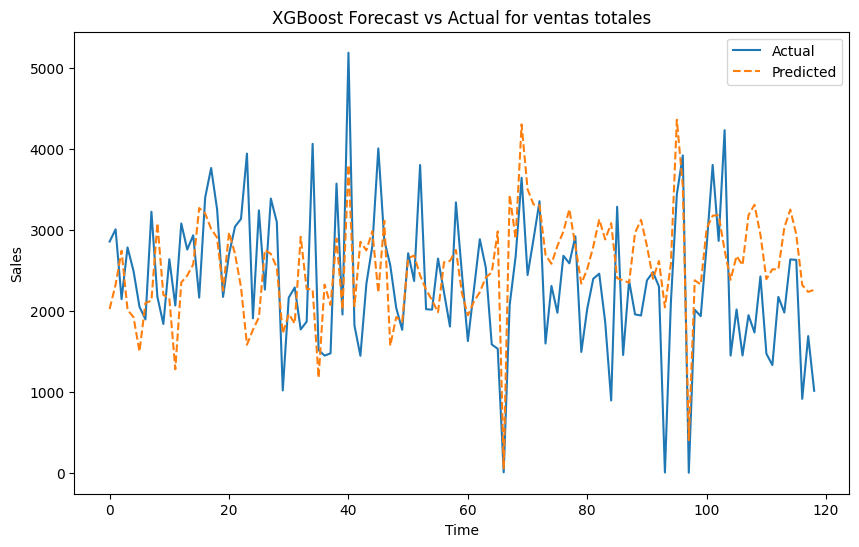

In [113]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características adicionales a partir de la columna de fechas 'ds'
df_train['ds'] = pd.to_datetime(df_train['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df_train['day_of_week'] = df_train['ds'].dt.dayofweek
df_train['day_of_month'] = df_train['ds'].dt.day
df_train['month'] = df_train['ds'].dt.month
df_train['year'] = df_train['ds'].dt.year
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_train y df_test
df_train = pd.merge(df_train, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_train['is_holiday'] = df_train['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_train = df_train.drop(columns=['holiday'], errors='ignore')

# Aseguramos que df_test tenga las mismas transformaciones
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test['day_of_week'] = df_test['ds'].dt.dayofweek
df_test['day_of_month'] = df_test['ds'].dt.day
df_test['month'] = df_test['ds'].dt.month
df_test['year'] = df_test['ds'].dt.year
df_test['is_weekend'] = df_test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear una nueva columna 'is_holiday' en df_test
df_test = pd.merge(df_test, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df_test['is_holiday'] = df_test['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df_test = df_test.drop(columns=['holiday'], errors='ignore')


# Dividimos los datos en variables predictoras (X) y objetivo (y)
X_train = df_train.drop(columns=['y', 'ds'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y', 'ds'])
y_test = df_test['y']

# Convertimos los datos a DMatrix, que es la estructura de datos que usa XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definimos los parámetros del modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'eval_metric': 'rmse',            # Usamos RMSE como métrica de evaluación
    'max_depth': 6,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'n_estimators': 100,              # Número de árboles
    'seed': 42                        # Fijamos una semilla para reproducibilidad
}

# Entrenamos el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizamos predicciones en el conjunto de test
y_pred = model.predict(dtest)

# Calculamos el error cuadrático medio (RMSE) en el conjunto de test
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calculamos el MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Opción: convertir a DataFrame las predicciones
df_results = pd.DataFrame({'Fecha': df_test['ds'], 'Actual': y_test, 'Predicted': y_pred})

print()

# Mostrar resultados
print(df_results.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual')
plt.plot(df_results['Predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

RMSE en el conjunto de test: 826.6933347380839
MSE en el conjunto de test: 683421.8697003736
MAPE en el conjunto de test: 254.30%


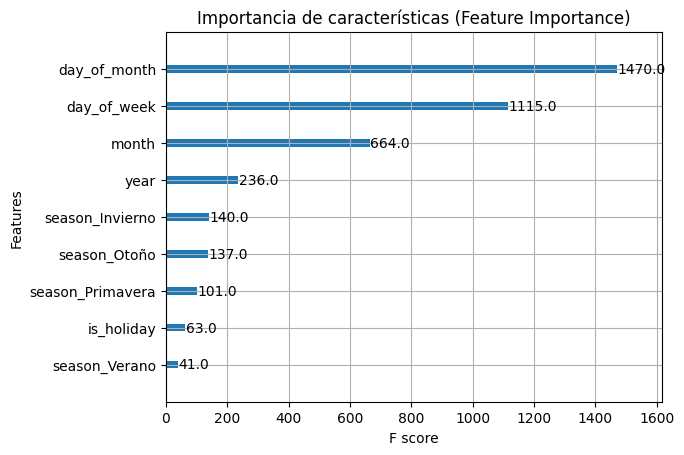

In [114]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Entrenar el modelo con el conjunto de entrenamiento
model = xgb.train(params, dtrain, num_boost_round=100)

# Realizar la predicción
y_pred = model.predict(dtest)

# Calcular el RMSE y MAPE como antes
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")
print(f"MSE en el conjunto de test: {mse}")

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en el conjunto de test: {mape:.2f}%")

# Importancia de las características
xgb.plot_importance(model)
plt.title('Importancia de características (Feature Importance)')
plt.show()